Starting the main pipeline...
Loading images and extracting features...
Starting feature extraction from images...
Feature extraction completed.
Encoding labels...
Splitting data into train and test sets...
Constructing the visual vocabulary from training data...
Building visual vocabulary using KMeans clustering...
Vocabulary building completed.
Computing combined features for training data...
Computing combined features for testing data...
Applying feature scaling...
Initializing models with CUDA support where available...
Starting model training and evaluation...

Training XGBoost...


c:\users\surya\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
c:\users\surya\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\users\surya\appdata\local\programs\python\python39\lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:52] WARNING: C:\buildkite-

XGBoost Accuracy: 0.8350


<Figure size 800x600 with 0 Axes>

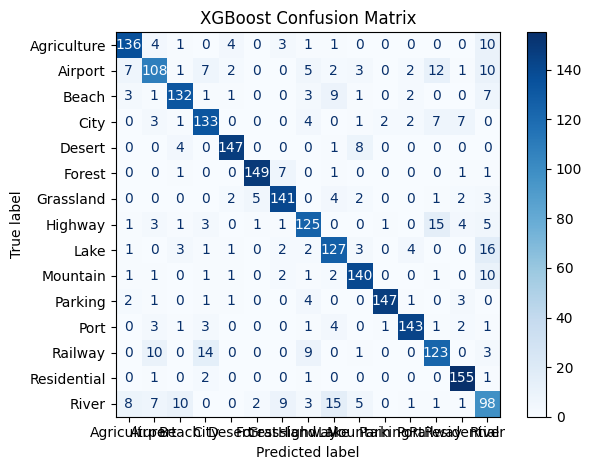


Training LightGBM...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 159136
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 706
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 546 dense feature groups (5.02 MB) transferred to GPU in 0.007589 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM

<Figure size 800x600 with 0 Axes>

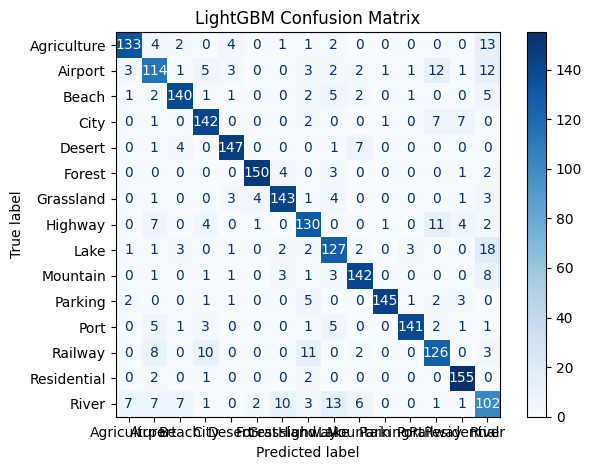


Training CatBoost...
CatBoost Accuracy: 0.8442


<Figure size 800x600 with 0 Axes>

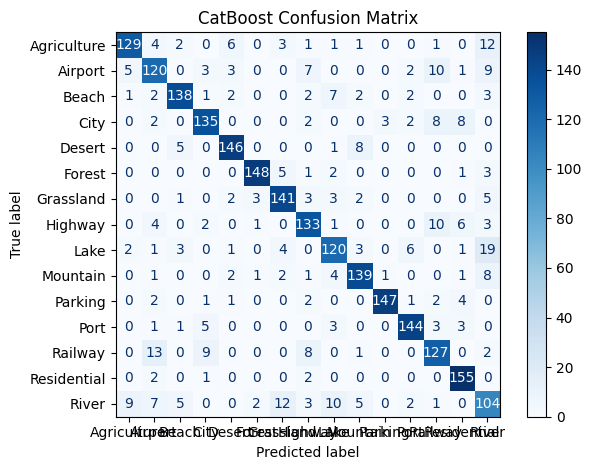


Training SVM...
SVM Accuracy: 0.7900


<Figure size 800x600 with 0 Axes>

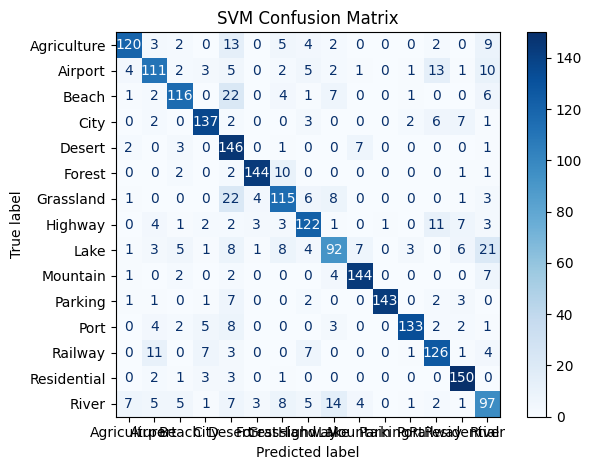


Training RandomForest...
RandomForest Accuracy: 0.7604


<Figure size 800x600 with 0 Axes>

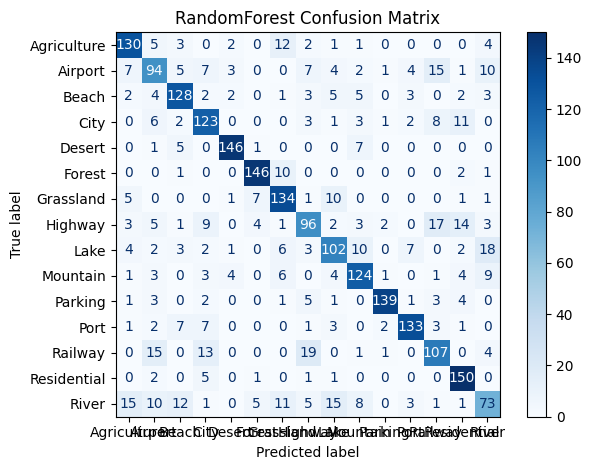


Training KNN...
KNN Accuracy: 0.6529


<Figure size 800x600 with 0 Axes>

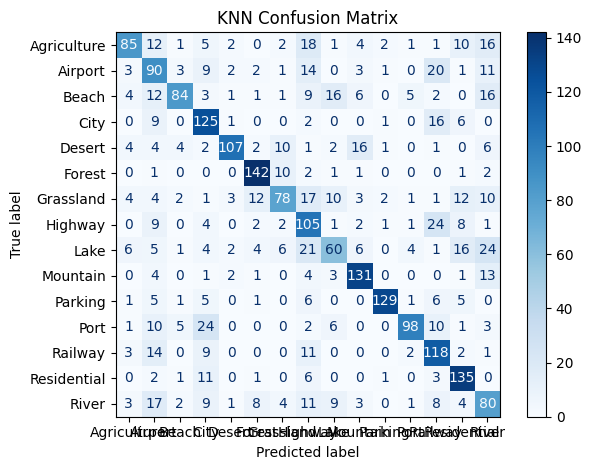

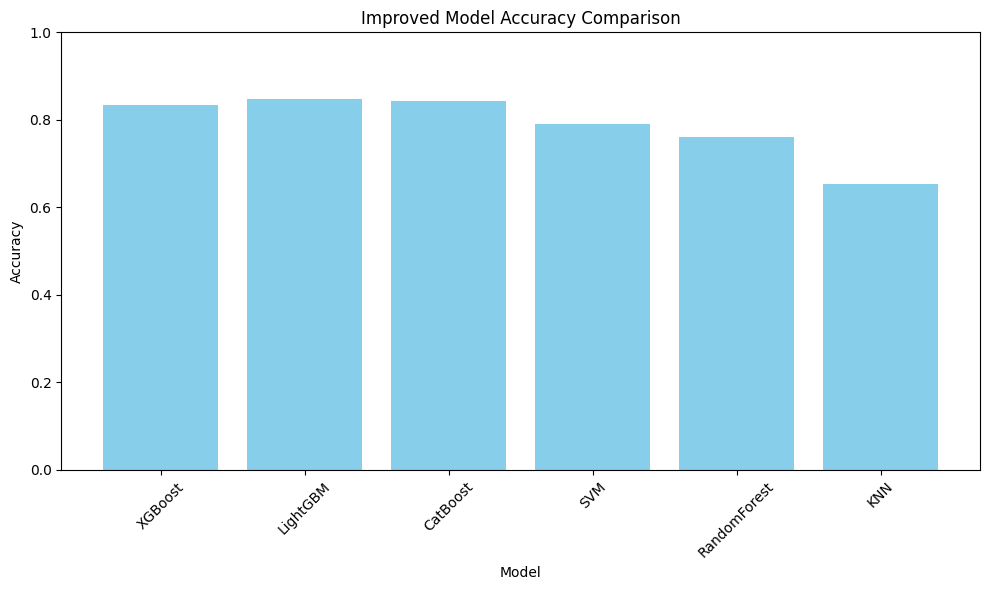

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from skimage.feature.texture import graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder

def load_combined_features(dataset_dir, image_size=(256, 256)):
    print("Starting feature extraction from images...")
    X_desc, y = [], []
    class_names = sorted(d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d)))
    sift = cv2.SIFT_create(nfeatures=600, contrastThreshold=0.03)

    for label in class_names:
        folder = os.path.join(dataset_dir, label)
        for file in os.listdir(folder):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(folder, file)
                image = cv2.imread(path)
                if image is None:
                    continue

                image_resized = cv2.resize(image, image_size)
                gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

                _, desc = sift.detectAndCompute(gray, None)

                hist = cv2.calcHist([image_resized], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
                hist = cv2.normalize(hist, hist).flatten()

                glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
                texture = np.hstack([
                    graycoprops(glcm, prop).flatten() 
                    for prop in ['contrast', 'homogeneity', 'energy', 'correlation']
                ])

                X_desc.append((desc, hist, texture))
                y.append(label)

    print("Feature extraction completed.")
    return X_desc, y

def build_vocabulary(descriptor_list, vocab_size=500):
    print("Building visual vocabulary using KMeans clustering...")
    valid_descriptors = [desc for desc, _, _ in descriptor_list if desc is not None]
    all_descriptors = np.vstack(valid_descriptors)
    kmeans = KMeans(n_clusters=vocab_size, random_state=42)
    kmeans.fit(all_descriptors)
    print("Vocabulary building completed.")
    return kmeans


def compute_combined_features(features, kmeans, vocab_size):
    desc, color_hist, texture = features

    if desc is None or desc.size == 0:
        bow_hist = np.zeros(vocab_size)
    else:
        clusters = kmeans.predict(desc)
        bow_hist, _ = np.histogram(clusters, bins=np.arange(vocab_size+1))
        bow_hist = bow_hist.astype("float32") / (bow_hist.sum() + 1e-6)

    return np.hstack([bow_hist, color_hist, texture])


def main():
    print("Starting the main pipeline...")
    dataset_dir = r"C:\Users\surya\OneDrive\Desktop\assignments\cv\project\archive\Aerial_Landscapes"
    print("Loading images and extracting features...")
    X_desc, y = load_combined_features(dataset_dir)

    print("Encoding labels...")
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    print("Splitting data into train and test sets...")
    X_train_desc, X_test_desc, y_train, y_test = train_test_split(
        X_desc, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

    vocab_size = 500
    print("Constructing the visual vocabulary from training data...")
    kmeans = build_vocabulary(X_train_desc, vocab_size)

    print("Computing combined features for training data...")
    X_train = np.array([compute_combined_features(d, kmeans, vocab_size) for d in X_train_desc])
    print("Computing combined features for testing data...")
    X_test = np.array([compute_combined_features(d, kmeans, vocab_size) for d in X_test_desc])

    print("Applying feature scaling...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Initializing models with CUDA support where available...")
    models = {
        
        "XGBoost": xgb.XGBClassifier(
            eval_metric='mlogloss',
            tree_method='gpu_hist',   
            predictor='gpu_predictor', 
            gpu_id=0
        ),
       
        "LightGBM": lgb.LGBMClassifier(
            device='gpu',           
            gpu_platform_id=0,       
            gpu_device_id=0         
        ),
      
        "CatBoost": CatBoostClassifier(
            task_type='GPU',       
            devices='0',           
            verbose=0
        ),
       
        "SVM": SVC(),
        "RandomForest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier()
    }

    results = {}
    print("Starting model training and evaluation...")
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        features = X_train_scaled if name in ["SVM", "KNN"] else X_train
        model.fit(features, y_train)

        test_features = X_test_scaled if name in ["SVM", "KNN"] else X_test
        preds = model.predict(test_features)

        acc = accuracy_score(y_test, preds)
        cm = confusion_matrix(y_test, preds)
        results[name] = {"accuracy": acc, "confusion_matrix": cm}

        print(f"{name} Accuracy: {acc:.4f}")
        plt.figure(figsize=(8, 6))
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_).plot(cmap=plt.cm.Blues)
        plt.title(f"{name} Confusion Matrix")
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), [r["accuracy"] for r in results.values()], color='skyblue')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Improved Model Accuracy Comparison')
    plt.ylim([0, 1])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
